In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
cmap = matplotlib.colormaps.get('tab10').colors

In [32]:
def get_P_nodes(size=[10,10,10]):
    vec1 = np.arange(0,size[0],1)
    vec2 = np.arange(0,size[1],1)
    vec3 = np.arange(0,size[2],1)
    a, b, c = np.meshgrid(vec1,vec2, vec3)
    nodes = np.stack([a,b,c],axis=-1) # Stack them in a new axis
    nodes = np.reshape(nodes, (-1, 3)) # Reshape to an arr of nodes with shape (#nodes, 3)
    return nodes

def get_S_nodes(size=[10,10,10]):
    P = get_P_nodes(size)
    extra = P + np.array([0.5,0.5,0])
    return np.append(P,extra,axis=0)

def get_I_nodes(size=[10,10,10]):
    P = get_P_nodes(size)
    extra = P + 0.5
    return np.append(P,extra,axis=0)

def get_F_nodes(size=[10,10,10]):
    P = get_P_nodes(size)
    extra1 = P + np.array([0.5,0.5,0])
    extra2 = P + np.array([0,0.5,0.5])
    extra3 = P + np.array([0.5,0,0.5])
    return np.row_stack((P, extra1, extra2, extra3))

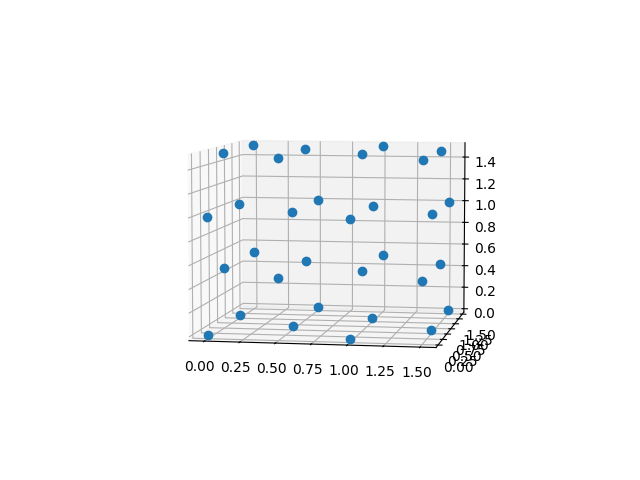

In [33]:
m = get_F_nodes([2,2,2])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(m[:,0], m[:,1], m[:,2], 'o', color=cmap[0])
#ax.plot([m[c[0],0], m[c[0],1], m[c[0],2]], [m[c[1],0], m[c[1],1], m[c[1],2]] , '-', color=cmap[1])
ax.view_init(6, -80, 0)

array([[0. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 1. ],
       [1. , 1. , 0. ],
       [1. , 1. , 1. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 1. ],
       [1.5, 0.5, 0. ],
       [1.5, 0.5, 1. ],
       [0.5, 1.5, 0. ],
       [0.5, 1.5, 1. ],
       [1.5, 1.5, 0. ],
       [1.5, 1.5, 1. ],
       [0. , 0.5, 0.5],
       [0. , 0.5, 1.5],
       [1. , 0.5, 0.5],
       [1. , 0.5, 1.5],
       [0. , 1.5, 0.5],
       [0. , 1.5, 1.5],
       [1. , 1.5, 0.5],
       [1. , 1.5, 1.5],
       [0.5, 0. , 0.5],
       [0.5, 0. , 1.5],
       [1.5, 0. , 0.5],
       [1.5, 0. , 1.5],
       [0.5, 1. , 0.5],
       [0.5, 1. , 1.5],
       [1.5, 1. , 0.5],
       [1.5, 1. , 1.5]])